In [1]:
import pandas as pd
import numpy as np
import os
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
package_root = os.getcwd()
# Construct paths relative to the package root directory
file = os.path.join(package_root, "generated_signals_rms015_2.csv")
df = pd.read_csv(file).to_numpy()

x_set = df[:,2:]
y_set = df[:,0]

# # data reduced
# x_set = df[:, 20:70]
# mask = x_set < 0
# x_set = (10**10)**np.abs(x_set)-1
# x_set[mask] *= -1


x_set = torch.from_numpy(x_set).type(torch.float).to(device)
y_set = torch.from_numpy(y_set).type(torch.LongTensor).to(device)


x_train, x_test, y_train, y_test = train_test_split(x_set, y_set, test_size=0.2, random_state=42)


In [3]:
class Photonsclassify_small(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
        nn.Linear(100, 32),
        # nn.BatchNorm1d(1024),  # Batch Normalization
        nn.ReLU(),
        # nn.Dropout(0.4),  
        nn.Linear(32, 16),
        # nn.BatchNorm1d(512),
        nn.ReLU(),
        # nn.BatchNorm1d(256),
        nn.Linear(16, 5))

    def forward(self, x):
        return self.network(x)

module = Photonsclassify_small().to(device)
print(module)

Photonsclassify_small(
  (network): Sequential(
    (0): Linear(in_features=100, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=5, bias=True)
  )
)


In [4]:
loss_fn = nn.CrossEntropyLoss()
optimizer1 = torch.optim.SGD(module.parameters(), lr=0.1)
optimizer2 = torch.optim.Adam(module.parameters(), lr=0.01)

In [5]:
# write acc function for different photons
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred.squeeze()).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

def con_accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred.squeeze())
    lab_0, lab_1, lab_2, lab_3, lab_4 = 0, 0, 0, 0, 0
    corr_0, corr_1, corr_01, corr_2, corr_3, corr_4 = 0, 0, 0, 0, 0, 0
    for i in range(len(y_true)):
        if y_true[i] == 0:
            lab_0 = lab_0 + 1
            if correct[i]: corr_0 = corr_0 + 1
        elif y_true[i] == 1:
            lab_1 = lab_1 + 1
            if y_pred.squeeze()[i] == 0: corr_01 = corr_01 + 1
            if correct[i]: corr_1 = corr_1 + 1
        elif y_true[i] == 2:
            lab_2 = lab_2 + 1
            if correct[i]: corr_2 = corr_2 + 1
        elif y_true[i] == 3:
            lab_3 = lab_3 + 1
            if correct[i]: corr_3 = corr_3 + 1
        elif y_true[i] == 4:
            lab_4 = lab_4 + 1
            if correct[i]: corr_4 = corr_4 + 1
        else: print("Wrong data ")
    print(f"zero:{lab_0}, single:{lab_1}, two:{lab_2}, three:{lab_3}, four:{lab_4}")
    return (corr_0/lab_0)*100, (corr_1/lab_1)*100, (corr_01+corr_1)/lab_1 * 100 ,(corr_2/lab_2)*100, (corr_3/lab_3)*100, (corr_4/lab_4)*100

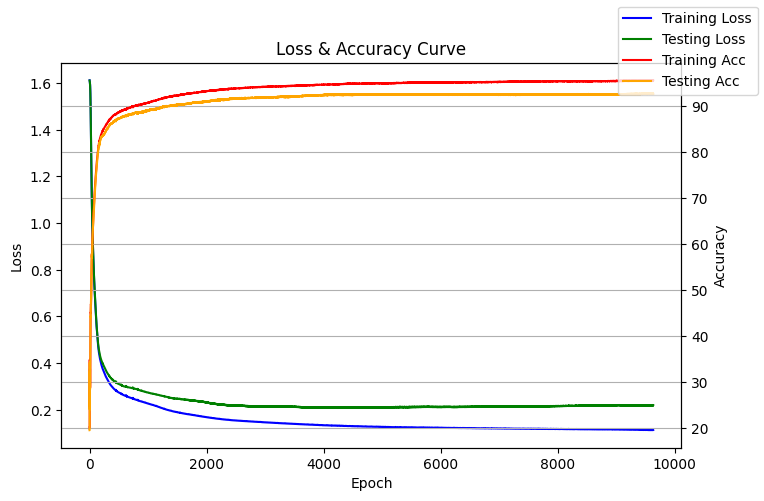

In [ ]:
# Training Part

torch.manual_seed(42)
epochs = 10000

train_losses = []
test_losses = []
train_accs = []
test_accs = []

for epoch in range(epochs):
    module.train()
    y_logits = module(x_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    loss = loss_fn(y_logits, y_train) 
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # if epoch < 4000:
    #     optimizer2.zero_grad()
    #     loss.backward()
    #     optimizer2.step()
    # else:
    #     optimizer1.zero_grad()
    #     loss.backward()
    #     optimizer1.step()

    optimizer2.zero_grad()
    loss.backward()
    optimizer2.step()

    module.eval()
    with torch.inference_mode():
        test_logits = module(x_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
      
    
    train_losses.append(loss.cpu().detach().numpy())
    test_losses.append(test_loss.cpu().detach().numpy())
    train_accs.append(acc)
    test_accs.append(test_acc)

    clear_output(wait=True)
    fig = plt.figure(figsize=(8,5))
    ax1 = fig.add_subplot(111)
    ax1.plot(train_losses, label='Training Loss', color='blue')
    ax1.plot(test_losses,  label='Testing Loss', color='Green')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')

    ax2 = ax1.twinx()
    ax2.plot(train_accs, label='Training Acc', color='red')
    ax2.plot(test_accs,  label='Testing Acc', color='orange')
    ax2.set_ylabel('Accuracy')

    plt.title('Loss & Accuracy Curve')
    fig.legend()
    plt.grid()
    plt.show()

    # if epoch % int(epochs/10) ==0:
    #     print(f"epo:{epoch}|loss:{loss:.5f}, Ac:{acc:.5f}|testloss:{test_loss:.5f}, testac:{test_acc:.5f}")
        

In [7]:
module.eval()
with torch.inference_mode():
    y_logits = module(x_test)

y_pred_lab = torch.argmax(y_logits, dim=1)
print(f"Test accuracy(overall): {accuracy_fn(y_true=y_test, y_pred=y_pred_lab):.5f}%")
acc0, acc1, acc01, acc2, acc3, acc4 = con_accuracy_fn(y_true=y_test, y_pred=y_pred_lab)
print(f"Condition accuracy:P(0|0)={acc0:.5f}%, P(1|1)={acc1:.5f}%, P(0|1)+P(1|1)={acc01:.5f}%, P(2|2)={acc2:.5f}%, P(3|3)={acc3:.5f}%, P(4|4)={acc4:.5f}%")

Test accuracy(overall): 94.86500%
zero:4052, single:5941, two:5938, three:2036, four:2033
Condition accuracy:P(0|0)=99.80257%, P(1|1)=99.02373%, P(0|1)+P(1|1)=99.09106%, P(2|2)=96.36241%, P(3|3)=80.00982%, P(4|4)=83.37432%


In [8]:
from pathlib import Path
MODEL_PATH = Path("models")

MODEL_NAME = "photon_count_model_rms015_04.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=module.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models\photon_count_model_rms015_04.pth


In [9]:
file = "generated_signals_verify_rms015.csv"
df = pd.read_csv(file).to_numpy()

x_verify = df[:, 2:]
y_verify = df[:,0]
x_verify = torch.from_numpy(x_verify).type(torch.float).to(device)
y_verify = torch.from_numpy(y_verify).type(torch.LongTensor).to(device)

In [10]:
loaded_model = Photonsclassify_small()
loaded_model.load_state_dict(torch.load(f="models\photon_count_model_rms015_04.pth"))
loaded_model.to(device)
loaded_model.eval()
with torch.inference_mode():
    loaded_model_logits = loaded_model(x_verify)

loaded_model_pred_lab = torch.argmax(loaded_model_logits, dim=1)
print(f"Test accuracy(overall): {accuracy_fn(y_true=y_verify, y_pred=loaded_model_pred_lab):.5f}%")
acc0, acc1, acc01, acc2, acc3, acc4 = con_accuracy_fn(y_true=y_verify, y_pred=loaded_model_pred_lab)
print(f"Condition accuracy:P(0|0)={acc0:.5f}%, P(1|1)={acc1:.5f}%, P(0|1)+P(1|1)={acc01:.5f}%,  P(2|2)={acc2:.5f}%, P(3|3)={acc3:.5f}%, P(4|4)={acc4:.5f}%")

<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
C:\Users\tangh\AppData\Local\Temp\ipykernel_35436\2927870848.py:2: SyntaxWarning: invalid escape sequence '\p'
  loaded_model.load_state_dict(torch.load(f="models\photon_count_model_rms015_04.pth"))
C:\Users\tangh\AppData\Local\Temp\ipykernel_35436\2927870848.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.se

Test accuracy(overall): 91.78000%
zero:1957, single:2019, two:1991, three:1974, four:2059
Condition accuracy:P(0|0)=99.79561%, P(1|1)=99.00941%, P(0|1)+P(1|1)=99.05894%,  P(2|2)=96.83576%, P(3|3)=77.76089%, P(4|4)=85.62409%
